# Importing Modules and Image Data

In [1]:
#!pip show opencv-python

Name: opencv-python
Version: 4.8.1.78
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /Users/vinayakbassi/opt/anaconda3/lib/python3.9/site-packages
Requires: numpy, numpy, numpy
Required-by: 


In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow
import IPython

In [4]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1dDdk7IrM5oO2gA57_bapqdIgk7CmJV03"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=1V_lui-asfT3Xly4O_Kuez8IDYEZkct4i"
! wget -O orion.jpg "https://drive.google.com/uc?export=download&id=1L1deUWfJbdtss4liHii8Luhnl2RG_ITl"
! wget -O point_tracker.html "https://drive.google.com/uc?export=download&id=1I9Xw8u0EdAEsP4GGuNwh267zL5lwxQw_"


# Visualize original image

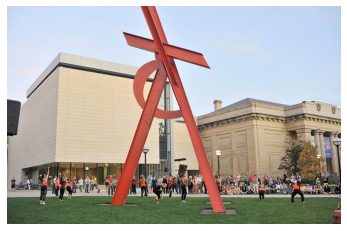

In [5]:
orion_img = cv2.imread('orion.jpg')
orion_img = cv2.cvtColor(orion_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.axis('off')
plt.imshow(orion_img)

# Visualize image after bayer filter is applied (Colored and greyscale)

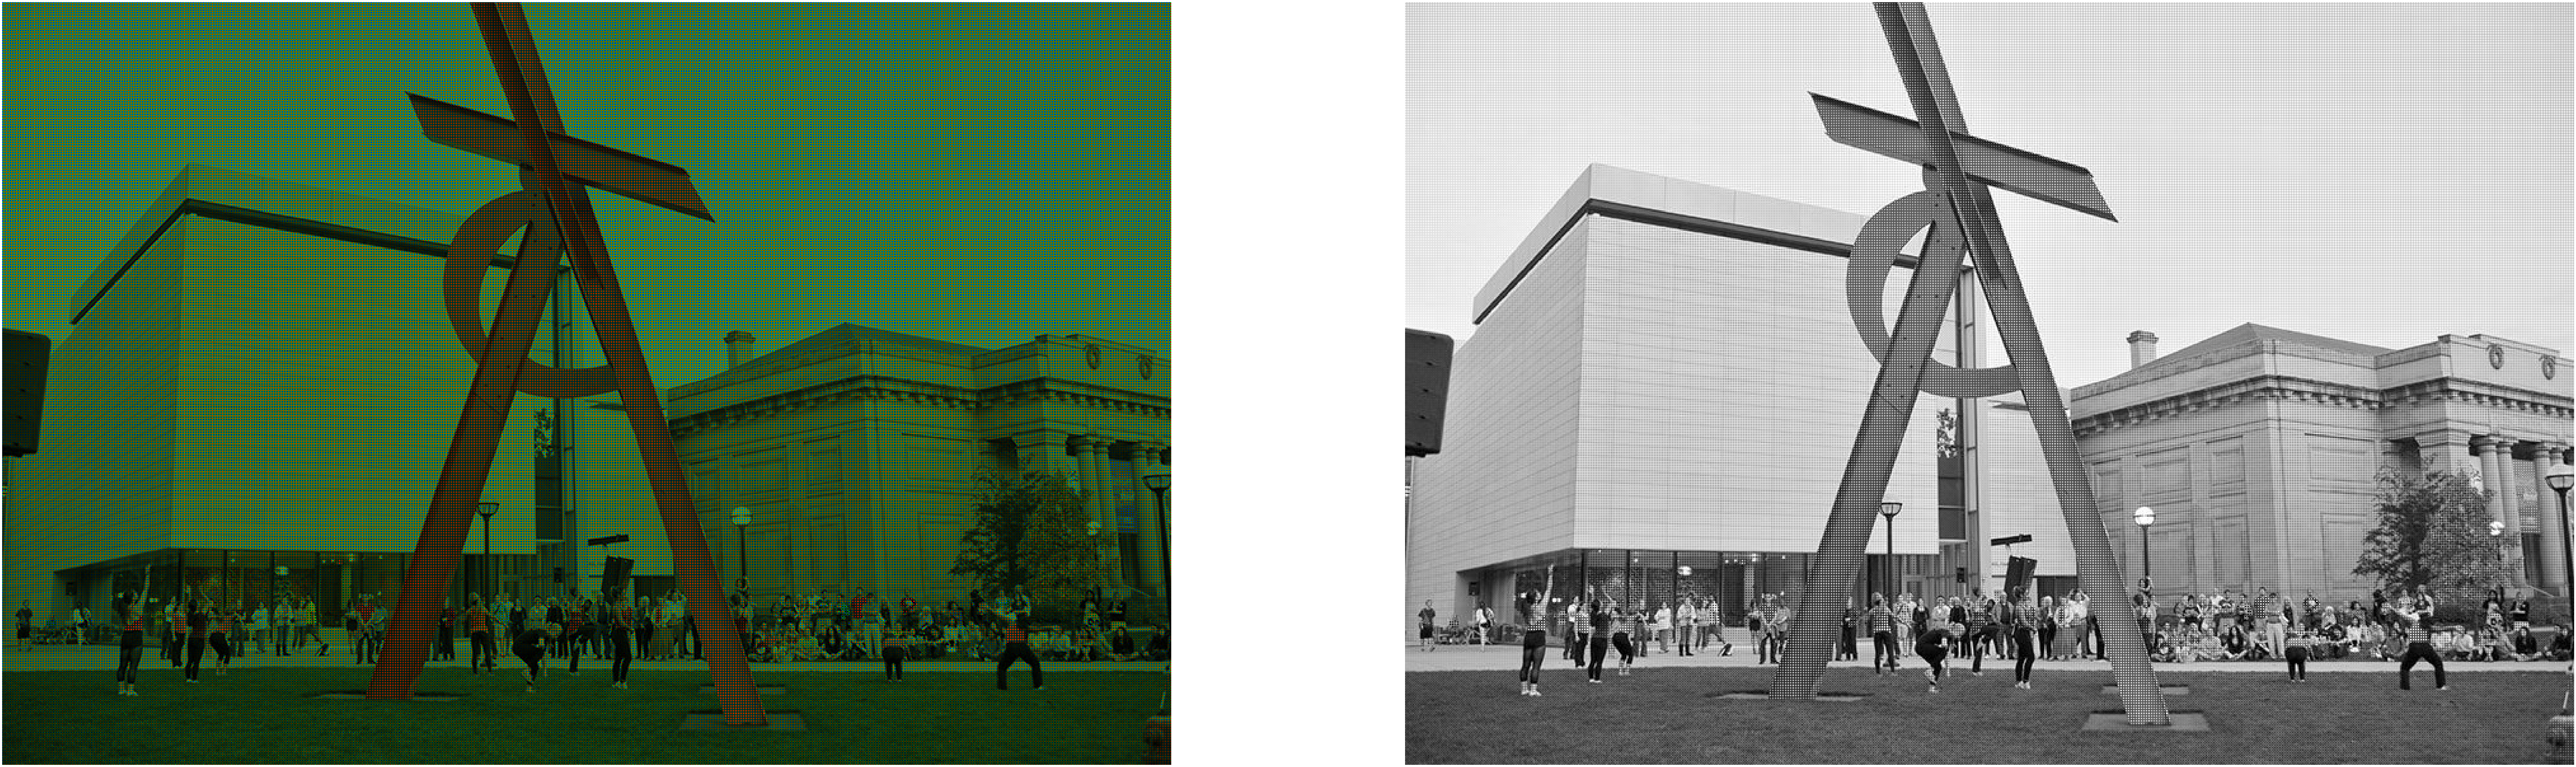

In [6]:
def bayer_filter(img):
  # function bayer_filter filters an input color image I
  # by the Bayer pattern as below, and outputs a filtered color
  # image I and a gray scaled image I_gray in which the
  # value of every pixel is the intensity of corresponding
  # color.
  # b | g
  # -----
  # g | r


  rows, cols, _ = img.shape

  colored = img.copy()

  mask = np.zeros((2,2,3))
  mask[0,0,:] = [0,0,1] #blue
  mask[0,1,:] = [0,1,0] #green
  mask[1,0,:] = [0,1,0] #green
  mask[1,1,:] = [1,0,0] #red

  for row in range(rows):
    mask_row = row%2

    for col in range(cols):
      mask_col = col%2
      colored[row, col, :] = colored[row, col, :] * mask[mask_row, mask_col, :]

  gray = colored[:, :, 0] + colored[:, :, 1] + colored[:, :, 2]

  return colored, gray



filtered_img, gray_img = bayer_filter(orion_img)

fig, ax = plt.subplots(1, 2, figsize=(150, 200))
for a in ax:
  a.set_axis_off()
ax[0].imshow(filtered_img)
ax[1].imshow(gray_img, cmap="gray")




# Demosaicing

In [7]:
# ===============================================

def four_neighbors_average(gray_img, row, col):
  # Computes the average of the four neighborgh pixels (left, right, top and bottom).
  # REMEMBER that for the pixels on the border, we only consider the neighboring pixels within the image domain.


  M, N = gray_img.shape
  neighbors = []
  if col - 1 >= 0: neighbors.append(gray_img[row, col - 1])  # Left
  if col + 1 < N: neighbors.append(gray_img[row, col + 1])  # Right
  if row - 1 >= 0: neighbors.append(gray_img[row - 1, col])  # Up
  if row + 1 < M: neighbors.append(gray_img[row + 1, col]) # Down

  return sum(neighbors) / len(neighbors)

def four_corners_average(gray_img, row, col):
  # Computes the average of the four corner pixels (top-left, top-right, bottom-left, bottom-right).
  # REMEMBER that for the pixels on the border, we only consider the neighboring pixels within the image domain.

 
  M, N = gray_img.shape
  corners = []
  if row - 1 >= 0 and col - 1 >= 0: corners.append(gray_img[row - 1, col - 1])  # Top-left
  if row - 1 >= 0 and col + 1 < N: corners.append(gray_img[row - 1, col + 1])  # Top-right
  if row + 1 < M and col - 1 >= 0: corners.append(gray_img[row + 1, col - 1])  # Bottom-left
  if row + 1 < M and col + 1 < N: corners.append(gray_img[row + 1, col + 1])  # Bottom-right

  return sum(corners) / len(corners)

def left_right_average(gray_img, row, col):
  # Computes the average of the left and right pixels.
  # REMEMBER that for the pixels on the border, we only consider the neighboring pixels within the image domain.


  N = gray_img.shape[1]
  neighbors = []
  if col - 1 >= 0: neighbors.append(gray_img[row, col - 1])  # Left
  if col + 1 < N: neighbors.append(gray_img[row, col + 1])  # Right

  return sum(neighbors) / len(neighbors)

def top_bottom_average(gray_img, row, col):
  # Computes the average of the top and bottom pixels.
  # REMEMBER that for the pixels on the border, we only consider the neighboring pixels within the image domain.

  
  M = gray_img.shape[0]
  neighbors = []
  if row - 1 >= 0: neighbors.append(gray_img[row - 1, col])  # Up
  if row + 1 < M: neighbors.append(gray_img[row + 1, col])  # Down

  return sum(neighbors) / len(neighbors)


# ===============================================

In [8]:
# ===============================================

def demosaic(gray_img):
  M, N = gray_img.shape
  colored_img = np.zeros((M, N, 3), dtype=np.uint8)

  for row in range(M):
      for col in range(N):
          if row % 2 == 0 and col % 2 == 0:  # Blue
              colored_img[row, col, 2] = gray_img[row, col]
              colored_img[row, col, 1] = four_neighbors_average(gray_img, row, col)
              colored_img[row, col, 0] = four_corners_average(gray_img, row, col)
          elif row % 2 == 0 and col % 2 == 1:  # Green (BG)
              colored_img[row, col, 1] = gray_img[row, col]
              colored_img[row, col, 2] = left_right_average(gray_img, row, col)
              colored_img[row, col, 0] = top_bottom_average(gray_img, row, col)
          elif row % 2 == 1 and col % 2 == 0:  # Green (GR)
              colored_img[row, col, 1] = gray_img[row, col]
              colored_img[row, col, 2] = top_bottom_average(gray_img, row, col)
              colored_img[row, col, 0] = left_right_average(gray_img, row, col)
          else:  # Red
              colored_img[row, col, 0] = gray_img[row, col]
              colored_img[row, col, 1] = four_neighbors_average(gray_img, row, col)
              colored_img[row, col, 2] = four_corners_average(gray_img, row, col)

  return colored_img
  

# ===============================================


# Visualize reconstructed image

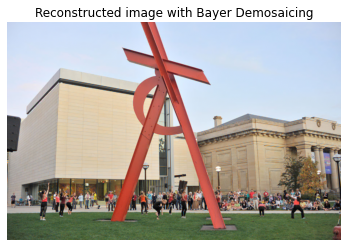

In [10]:
recon_img = demosaic(gray_img)
plt.figure()
plt.axis('off')
plt.title('Reconstructed image with Bayer Demosaicing')
plt.imshow(recon_img/255.)